In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time  # Import the time module for measuring execution time
from datetime import datetime  # Import datetime for getting the current date and time
import numpy as np
from pathlib import Path
import torchvision.utils as vutils
import os

In [2]:
# Modular Code Structure and Configuration and Import them
from train import train
from evaluate import test
from adv_test import adv_test
from attack import fgsm_attack
from defense import feature_squeeze, gaussian_blur

In [3]:
# Avoid fragmentation by limiting segment size
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [4]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
batch_size = 128
num_classes = 365

# epsilon for FGSM
epsilon = 8/255

root = Path("/content/data")

In [5]:
def get_dataloader(dataset_name, batch_size):

    train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader

In [6]:
use_cuda = True
# Define what device we are using
print("CUDA Available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True


In [7]:
dataset_name = 'MNIST'
model_list = 'ResNet50'

In [8]:
train_acc_results = {}
test_acc_results = {}
adv_acc_results = {}
feature_squeeze_test_acc_results = {}
gaussian_blur_test_acc_results = {}

images.shape = torch.Size([128, 1, 28, 28])
labels.shape = torch.Size([128])


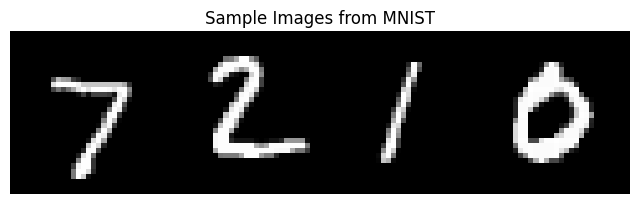

In [9]:
# Get train and test dataloader
train_loader, test_loader = get_dataloader(dataset_name, batch_size)

# Grab one batch
images, labels = next(iter(test_loader))

# Inspect shapes
print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

# Visualize the first 4 images with their class names
grid = vutils.make_grid(images[:4], nrow=4, normalize=True)
plt.figure(figsize=(8,3))
plt.imshow(grid.permute(1,2,0))
plt.title(f"Sample Images from {dataset_name}")
plt.axis('off')
plt.show()

In [10]:
print("==========================================")
print(f"Processing {dataset_name} dataset...")
print("==========================================")

# Create two models: Load pretrained ResNet and move to channels_last + device
model_clean = models.resnet18(pretrained=True).to(device)
model_clean.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)
model_adv = models.resnet18(pretrained=True).to(device)
model_adv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)

# Use SGD with momentum and weight decay (common for robust models)
optimizer_clean = optim.SGD(model_clean.parameters(), lr=learning_rate)
optimizer_adv = optim.SGD(model_adv.parameters(), lr=learning_rate)

torch.cuda.empty_cache()

print(f"Clean Training {dataset_name} dataset...")
start_time = time.time()
train_acc = train(model_clean, device, optimizer_clean, train_loader, num_epochs, epsilon=0, adversarial=False)
train_acc_results[model_list] = train_acc
end_time = time.time()
print(f"Training time for {dataset_name}: {end_time - start_time:.2f} seconds\n")
torch.cuda.empty_cache()

start_time = time.time()
print(f"Evaluating clean test accuracy for {dataset_name}...")
test_acc = test(model_clean, device, test_loader, num_epochs)
test_acc_results[model_list] = test_acc
end_time = time.time()
print(f"Testing time for {dataset_name}: {end_time - start_time:.2f} seconds\n")
torch.cuda.empty_cache()

# Evaluate adversarial accuracy with FGSM
start_time = time.time()
print(f"Evaluating adversarial accuracy for {dataset_name} with FGSM...")
adv_acc = adv_test(model_adv, device, test_loader, epsilon, num_epochs)
adv_acc_results[model_list] = adv_acc
end_time = time.time()
print(f"Adversarial testing time for {dataset_name}: {end_time - start_time:.2f} seconds\n")
torch.cuda.empty_cache()

# Apply feature_squeeze defense on adversarial examples:
start_time = time.time()  # Start timer
print(f"Evaluating test accuracy for {dataset_name} with Feature Squeezing...")
feature_squeeze_test_acc = test(model_clean, device, test_loader, num_epochs, defense_fn=feature_squeeze, defense_params={'bit_depth': 2})
feature_squeeze_test_acc_results[model_list] = feature_squeeze_test_acc
end_time = time.time()  # End timer
testing_time = end_time - start_time
print(f"Total Testing Time with Feature Squeezing in {dataset_name}: {testing_time} seconds\n")
torch.cuda.empty_cache()

start_time = time.time()  # Start timer
print(f"Evaluating test accuracy for {dataset_name} with Gaussian Blur...")
gaussian_blur_test_acc = test(model_clean, device, test_loader, num_epochs, defense_fn=gaussian_blur, defense_params={'kernel_size': 3, 'sigma': 1.0})
gaussian_blur_test_acc_results[model_list] = gaussian_blur_test_acc
end_time = time.time()  # End timer
testing_time = end_time - start_time
print(f"Total Testing Time with Gaussian Blur in {dataset_name}: {testing_time} seconds\n")
torch.cuda.empty_cache()


Processing MNIST dataset...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clean Training MNIST dataset...
Start Training ...


Epoch 1/10: 469it [00:18, 25.56it/s]

Train Epoch 1:: Accuracy: 44692/60000 (74%)



Epoch 2/10: 469it [00:19, 24.50it/s]

Train Epoch 2:: Accuracy: 55712/60000 (93%)



Epoch 3/10: 469it [00:20, 23.17it/s]

Train Epoch 3:: Accuracy: 57112/60000 (95%)



Epoch 4/10: 469it [00:19, 24.44it/s]

Train Epoch 4:: Accuracy: 57737/60000 (96%)



Epoch 5/10: 469it [00:19, 24.05it/s]

Train Epoch 5:: Accuracy: 58156/60000 (97%)



Epoch 6/10: 469it [00:19, 24.29it/s]

Train Epoch 6:: Accuracy: 58395/60000 (97%)



Epoch 7/10: 469it [00:18, 25.31it/s]

Train Epoch 7:: Accuracy: 58586/60000 (98%)



Epoch 8/10: 469it [00:20, 22.85it/s]

Train Epoch 8:: Accuracy: 58807/60000 (98%)



Epoch 9/10: 469it [00:19, 23.68it/s]

Train Epoch 9:: Accuracy: 58971/60000 (98%)



Epoch 10/10: 469it [00:19, 23.98it/s]


Train Epoch 10:: Accuracy: 59089/60000 (98%)
Finished Training
Training time for MNIST: 195.06 seconds

Evaluating clean test accuracy for MNIST...
Start Testing ...


Epoch 1/10: 79it [00:00, 79.15it/s]/s]
 10%|█         | 1/10 [00:01<00:09,  1.07s/it]

Test Epoch 1:: Accuracy: 9677/10000 (97%)


Epoch 2/10: 79it [00:00, 89.71it/s]
 20%|██        | 2/10 [00:02<00:07,  1.01it/s]

Test Epoch 2:: Accuracy: 9677/10000 (97%)


Epoch 3/10: 79it [00:00, 91.01it/s]
 30%|███       | 3/10 [00:02<00:06,  1.04it/s]

Test Epoch 3:: Accuracy: 9677/10000 (97%)


Epoch 4/10: 79it [00:00, 89.40it/s]
 40%|████      | 4/10 [00:03<00:05,  1.04it/s]

Test Epoch 4:: Accuracy: 9677/10000 (97%)


Epoch 5/10: 79it [00:00, 85.99it/s]
 50%|█████     | 5/10 [00:04<00:04,  1.04it/s]

Test Epoch 5:: Accuracy: 9677/10000 (97%)


Epoch 6/10: 79it [00:00, 87.17it/s]
 60%|██████    | 6/10 [00:05<00:03,  1.03it/s]

Test Epoch 6:: Accuracy: 9677/10000 (97%)


Epoch 7/10: 79it [00:00, 88.45it/s]
 70%|███████   | 7/10 [00:06<00:02,  1.03it/s]

Test Epoch 7:: Accuracy: 9677/10000 (97%)


Epoch 8/10: 79it [00:00, 92.39it/s]
 80%|████████  | 8/10 [00:07<00:01,  1.05it/s]

Test Epoch 8:: Accuracy: 9677/10000 (97%)


Epoch 9/10: 79it [00:00, 90.27it/s]
 90%|█████████ | 9/10 [00:08<00:00,  1.05it/s]

Test Epoch 9:: Accuracy: 9677/10000 (97%)


Epoch 10/10: 79it [00:00, 83.02it/s]
100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Test Epoch 10:: Accuracy: 9677/10000 (97%)
Finished Testing
Testing time for MNIST: 9.74 seconds

Evaluating adversarial accuracy for MNIST with FGSM...
Start Adversarial Examples Testing ...


ε=0.03137254901960784: 79it [00:01, 74.22it/s]

Epoch 1: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:00, 79.92it/s]

Epoch 2: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 68.13it/s]

Epoch 3: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 69.43it/s]

Epoch 4: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 72.81it/s]

Epoch 5: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 70.84it/s]

Epoch 6: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 70.42it/s]

Epoch 7: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 69.10it/s]

Epoch 8: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 73.86it/s]

Epoch 9: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)



ε=0.03137254901960784: 79it [00:01, 73.11it/s]


Epoch 10: Epsilon: 0.03137254901960784	Accuracy: 0/10000 (0%)
Finished Adversarial Examples Testing

Adversarial testing time for MNIST: 11.62 seconds

Evaluating test accuracy for MNIST with Feature Squeezing...
Start Testing ...


Epoch 1/10: 79it [00:00, 88.10it/s]/s]
 10%|█         | 1/10 [00:00<00:08,  1.04it/s]

Test Epoch 1:: Accuracy: 9670/10000 (97%)


Epoch 2/10: 79it [00:00, 87.75it/s]
 20%|██        | 2/10 [00:01<00:07,  1.04it/s]

Test Epoch 2:: Accuracy: 9670/10000 (97%)


Epoch 3/10: 79it [00:00, 87.52it/s]
 30%|███       | 3/10 [00:02<00:06,  1.03it/s]

Test Epoch 3:: Accuracy: 9670/10000 (97%)


Epoch 4/10: 79it [00:00, 87.07it/s]
 40%|████      | 4/10 [00:03<00:05,  1.03it/s]

Test Epoch 4:: Accuracy: 9670/10000 (97%)


Epoch 5/10: 79it [00:00, 89.27it/s]
 50%|█████     | 5/10 [00:04<00:04,  1.04it/s]

Test Epoch 5:: Accuracy: 9670/10000 (97%)


Epoch 6/10: 79it [00:00, 88.85it/s]
 60%|██████    | 6/10 [00:05<00:03,  1.04it/s]

Test Epoch 6:: Accuracy: 9670/10000 (97%)


Epoch 7/10: 79it [00:00, 88.50it/s]
 70%|███████   | 7/10 [00:06<00:02,  1.04it/s]

Test Epoch 7:: Accuracy: 9670/10000 (97%)


Epoch 8/10: 79it [00:01, 75.49it/s]
 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]

Test Epoch 8:: Accuracy: 9670/10000 (97%)


Epoch 9/10: 79it [00:00, 88.70it/s]
 90%|█████████ | 9/10 [00:08<00:00,  1.01it/s]

Test Epoch 9:: Accuracy: 9670/10000 (97%)


Epoch 10/10: 79it [00:00, 90.17it/s]
100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Test Epoch 10:: Accuracy: 9670/10000 (97%)
Finished Testing
Total Testing Time with Feature Squeezing in MNIST: 9.751039505004883 seconds

Evaluating test accuracy for MNIST with Gaussian Blur...
Start Testing ...


Epoch 1/10: 79it [00:00, 88.64it/s]/s]
 10%|█         | 1/10 [00:00<00:08,  1.05it/s]

Test Epoch 1:: Accuracy: 9705/10000 (97%)


Epoch 2/10: 79it [00:00, 86.63it/s]
 20%|██        | 2/10 [00:01<00:07,  1.04it/s]

Test Epoch 2:: Accuracy: 9705/10000 (97%)


Epoch 3/10: 79it [00:00, 88.77it/s]
 30%|███       | 3/10 [00:02<00:06,  1.04it/s]

Test Epoch 3:: Accuracy: 9705/10000 (97%)


Epoch 4/10: 79it [00:00, 86.07it/s]
 40%|████      | 4/10 [00:03<00:05,  1.03it/s]

Test Epoch 4:: Accuracy: 9705/10000 (97%)


Epoch 5/10: 79it [00:00, 86.55it/s]
 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

Test Epoch 5:: Accuracy: 9705/10000 (97%)


Epoch 6/10: 79it [00:00, 86.55it/s]
 60%|██████    | 6/10 [00:05<00:03,  1.02it/s]

Test Epoch 6:: Accuracy: 9705/10000 (97%)


Epoch 7/10: 79it [00:00, 91.01it/s]
 70%|███████   | 7/10 [00:06<00:02,  1.04it/s]

Test Epoch 7:: Accuracy: 9705/10000 (97%)


Epoch 8/10: 79it [00:00, 86.14it/s]
 80%|████████  | 8/10 [00:07<00:01,  1.03it/s]

Test Epoch 8:: Accuracy: 9705/10000 (97%)


Epoch 9/10: 79it [00:00, 88.86it/s]
 90%|█████████ | 9/10 [00:08<00:00,  1.04it/s]

Test Epoch 9:: Accuracy: 9705/10000 (97%)


Epoch 10/10: 79it [00:00, 88.05it/s]
100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

Test Epoch 10:: Accuracy: 9705/10000 (97%)
Finished Testing
Total Testing Time with Gaussian Blur in MNIST: 9.662691354751587 seconds



In [11]:
avg_train_accuracy = np.mean(train_acc_results[model_list])
avg_test_accuracy = np.mean(test_acc_results[model_list])
avg_adv_accuracy = np.mean(adv_acc_results[model_list])
avg_fs_accuracy = np.mean(feature_squeeze_test_acc_results[model_list])
avg_gb_accuracy = np.mean(gaussian_blur_test_acc_results[model_list])

print(f"Average training accuracy in {dataset_name} of {model_list}: {avg_train_accuracy}%")
print(f"Average test accuracy in {dataset_name} of {model_list}: {avg_test_accuracy}%")
print(f"Average adversarial accuracy in FGSM attack in {dataset_name} of {model_list}: {avg_adv_accuracy}%")
print(f"Average feature squeeze accuracy in {dataset_name} of {model_list}: {avg_fs_accuracy}%")
print(f"Average gaussian blur accuracy in {dataset_name} of {model_list}: {avg_gb_accuracy}%")

Average training accuracy in MNIST of ResNet50: 94.54283333333333%
Average test accuracy in MNIST of ResNet50: 96.77%
Average adversarial accuracy in FGSM attack in MNIST of ResNet50: 0.0%
Average feature squeeze accuracy in MNIST of ResNet50: 96.70000000000002%
Average gaussian blur accuracy in MNIST of ResNet50: 97.04999999999998%


In [12]:
# Combine the data into series
labels = ['Train Clean', 'Test Clean']
model_list = ['ResNet50']
data_series = [
    [train_acc_results[m] for m in model_list],
    [test_acc_results[m] for m in model_list],
]

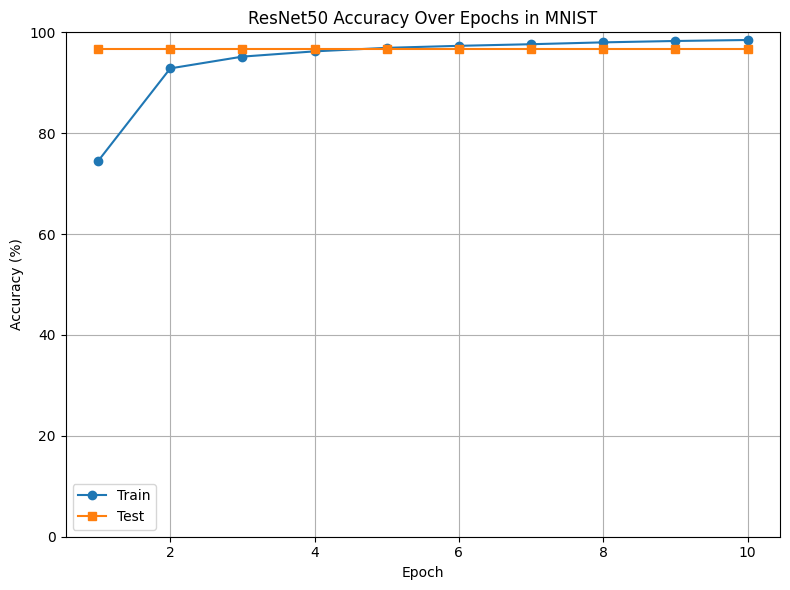

In [13]:
# Plot all types of accuracies for each dataset in subplots
fig, axs = plt.subplots(len(model_list), 1, figsize=(8, 6), sharex=True)

# num_epochs is an integer, but we need a range of epoch numbers for plotting
epoch_range = range(1, num_epochs + 1)  # Generate a list of epoch numbers [1, 2, ..., num_epochs]

# Guarantee axs is a 1D array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, model_name in zip(axs, model_list):
    ax.plot(epoch_range, train_acc_results[model_name],   label='Train', marker='o')
    ax.plot(epoch_range, test_acc_results[model_name],    label='Test',  marker='s')

    ax.set_title(f"{model_name} Accuracy Over Epochs in {dataset_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [14]:
# Combine the data into series
labels = ['FGSM Attack']
model_list = ['ResNet50']
data_series = [
    [adv_acc_results[m] for m in model_list],
]

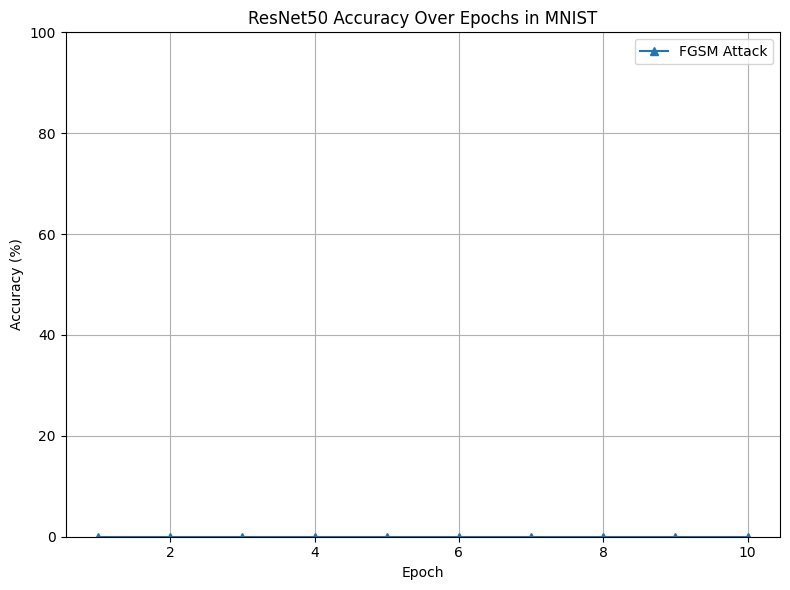

In [15]:
# Plot all types of accuracies for each dataset in subplots
fig, axs = plt.subplots(len(model_list), 1, figsize=(8, 6), sharex=True)

# num_epochs is an integer, but we need a range of epoch numbers for plotting
epoch_range = range(1, num_epochs + 1)  # Generate a list of epoch numbers [1, 2, ..., num_epochs]

# Guarantee axs is a 1D array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, model_name in zip(axs, model_list):
    ax.plot(epoch_range, adv_acc_results[model_name],     label='FGSM Attack',  marker='^')

    ax.set_title(f"{model_name} Accuracy Over Epochs in {dataset_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
# Combine the data into series
labels = ['Feature Squeeze', 'Gaussian Blur']
model_list = ['ResNet50']
data_series = [
    [feature_squeeze_test_acc_results[m] for m in model_list],
    [gaussian_blur_test_acc_results[m] for m in model_list]
]

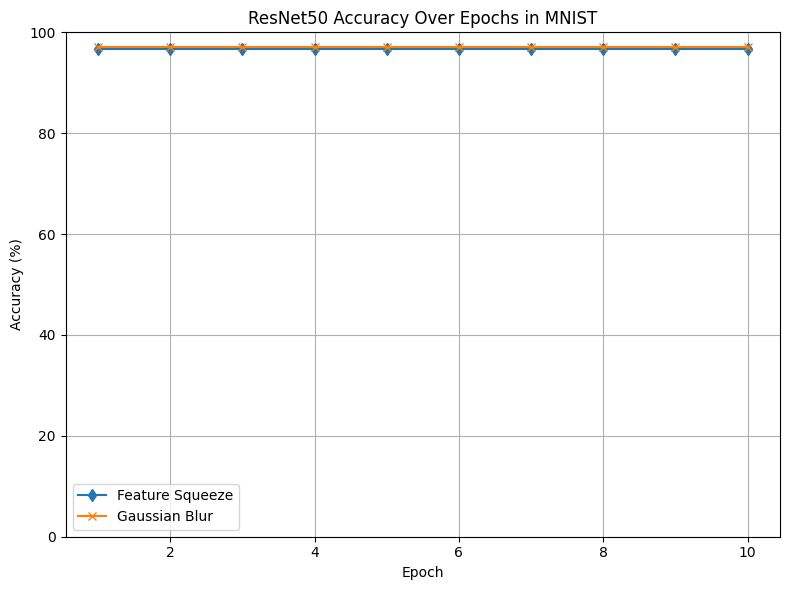

In [17]:
# Plot all types of accuracies for each dataset in subplots
fig, axs = plt.subplots(len(model_list), 1, figsize=(8, 6), sharex=True)

# num_epochs is an integer, but we need a range of epoch numbers for plotting
epoch_range = range(1, num_epochs + 1)  # Generate a list of epoch numbers [1, 2, ..., num_epochs]

# Guarantee axs is a 1D array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, model_name in zip(axs, model_list):
    ax.plot(epoch_range, feature_squeeze_test_acc_results[model_name],
            label='Feature Squeeze', marker='d')
    ax.plot(epoch_range, gaussian_blur_test_acc_results[model_name],
            label='Gaussian Blur', marker='x')

    ax.set_title(f"{model_name} Accuracy Over Epochs in {dataset_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()